The best resource for seeing the tiles and available files is this: https://lcviewer.vito.be/download

There are additional resources easily searchable via the interweb: https://land.copernicus.eu/global/content/annual-100m-global-land-cover-maps-available

In [1]:
import boto3
import geopandas as gpd
from rasterio.crs import CRS
from shapely.geometry import box
import rasterio
from tqdm import tqdm
import concurrent.futures
import json
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import Polygon
from tile_mate.tile_model import TILE_SCHEMA
from tile_mate.stitcher import DATA_DIR
from dem_stitcher.geojson_io import to_geojson_gzip
from tqdm import tqdm

In [2]:
YEARS = [2015, 2016, 2017, 2018, 2019]

# Read bucket

In [3]:
s3 = boto3.resource('s3')
s1_coh_bucket = s3.Bucket('vito.landcover.global')

In [4]:
%%time

objects_all = s1_coh_bucket.objects
tiles_by_year = [s1_coh_bucket.objects.filter(Prefix=f'v3.0.1/{year}/').all() for year in YEARS]

CPU times: user 51 µs, sys: 7 µs, total: 58 µs
Wall time: 58.9 µs


Sample url of something we want: https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2019/W120N40/W120N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif

In [6]:
%%time

coh_objs = [obj 
            for tiles_in_year in tiles_by_year
            for obj in tiles_in_year 
            if (obj.key[-41:-14] == 'Discrete-Classification-map') and 
            (obj.key[-13:] == 'EPSG-4326.tif')]
len(coh_objs)

CPU times: user 665 ms, sys: 83.9 ms, total: 749 ms
Wall time: 14.7 s


470

In [7]:
coh_data = [{'bucket': obj.bucket_name, 
             'key': obj.key} 
             for obj in coh_objs]

In [8]:
json_path = f'cop100_data.json'

In [9]:
json.dump(coh_data, open(json_path, 'w'))

# Load and Inspect

In [10]:
coh_s3_data = json.load(open(json_path))

In [11]:
data = coh_s3_data[0]
bucket = data['bucket']
key = data['key']
with rasterio.open(f's3://{bucket}/{key}') as ds:
    X = ds.read(1)
    p = ds.profile
data, p

({'bucket': 'vito.landcover.global',
  'key': 'v3.0.1/2015/E000N00/E000N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif'},
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 20160, 'height': 20160, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0009920634920634888, 0.0, 0.0,
        0.0, -0.0009920634920634888, 0.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'})

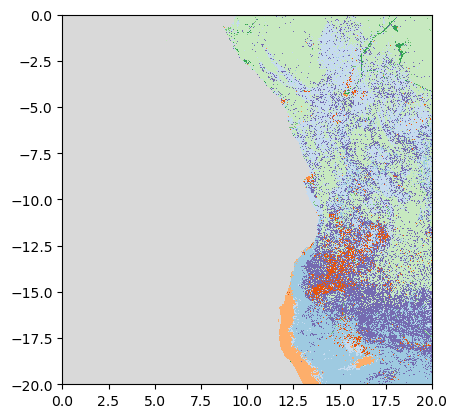

In [12]:
fig, ax=plt.subplots()
out = show(X, transform=p['transform'], ax=ax, cmap='tab20c', interpolation='none')

# Create GeoJSON

In [17]:
def build_url_and_update(data: dict) -> dict:
    bucket = data['bucket']
    key = data['key']
    url = f'https://s3-eu-west-1.amazonaws.com/{bucket}/{key}'
    data['url'] = url
    return data
    
def get_bounds_from_tile_id(tile_id: str) -> tuple[float]:
    lat_str = tile_id[4:]
    lon_str = tile_id[:4]
    lat = float(tile_id[5:])
    lon = float(tile_id[1:4])
    if 'S' in lat_str:
        lat = -lat
    if 'W' in lon_str:
        lon = -lon
    return lon, lat - 20, lon + 20, lat

def get_geometry_from_s3_data(data: dict) -> Polygon:
    tile_id = data['tile_id']
    bounds = get_bounds_from_tile_id(tile_id)
    return box(*bounds)

def get_tile_id_and_update(data: dict) -> dict:
    url = data['url']
    tile_id = url.split('/')[-2]
    data['tile_id'] = tile_id
    return data

def get_year_and_update(data: dict) -> dict:
    url = data['url']
    year = url.split('/')[-3]
    data['year'] = int(year)
    return data

In [18]:
data = coh_s3_data.copy()
data = list(map(build_url_and_update, tqdm(data)))
data = list(map(get_tile_id_and_update, tqdm(data)))
data = list(map(get_year_and_update, tqdm(data)))

geometry = list(map(get_geometry_from_s3_data, tqdm(data)))
data[0]

100%|████████████████████████████| 470/470 [00:00<00:00, 28618.01it/s]


{'bucket': 'vito.landcover.global',
 'key': 'v3.0.1/2015/E000N00/E000N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif',
 'url': 'https://s3-eu-west-1.amazonaws.com/vito.landcover.global/v3.0.1/2015/E000N00/E000N00_PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif',
 'tile_id': 'E000N00',
 'year': 2015}

CPU times: user 496 µs, sys: 112 µs, total: 608 µs
Wall time: 574 µs


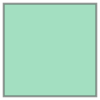

In [19]:
%%time
get_geometry_from_s3_data(data[0])

In [20]:
df = gpd.GeoDataFrame(coh_s3_data, geometry=geometry, crs=CRS.from_epsg(4326))
# We remove 
df = df.drop(columns=['key', 'bucket'])
df.head()

,url,tile_id,year,geometry
0,https://s3-eu-west-1.amazonaws.com/vito.landco...,E000N00,2015,"POLYGON ((20.00000 -20.00000, 20.00000 0.00000..."
1,https://s3-eu-west-1.amazonaws.com/vito.landco...,E000N20,2015,"POLYGON ((20.00000 0.00000, 20.00000 20.00000,..."
2,https://s3-eu-west-1.amazonaws.com/vito.landco...,E000N40,2015,"POLYGON ((20.00000 20.00000, 20.00000 40.00000..."
3,https://s3-eu-west-1.amazonaws.com/vito.landco...,E000N60,2015,"POLYGON ((20.00000 40.00000, 20.00000 60.00000..."
4,https://s3-eu-west-1.amazonaws.com/vito.landco...,E000N80,2015,"POLYGON ((20.00000 60.00000, 20.00000 80.00000..."


<Axes: >

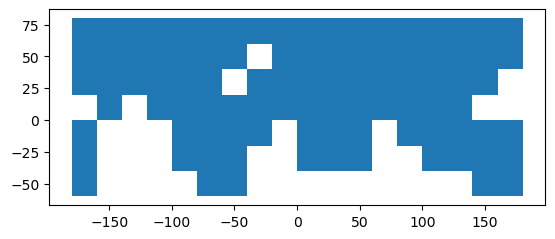

In [21]:
df.plot()

Sanity check

In [22]:
df_group = df.groupby('tile_id').count()
df_group

,url,year,geometry
tile_id,,,
E000N00,5,5,5
E000N20,5,5,5
E000N40,5,5,5
E000N60,5,5,5
E000N80,5,5,5
...,...,...,...
W180N40,5,5,5
W180N60,5,5,5
W180N80,5,5,5


In [23]:
df_group.url.unique() # all have 94 tiles (5 years * 94 total tiles = 270)

array([5])

In [24]:
df = TILE_SCHEMA.validate(df)

# Serialize

In [25]:
to_geojson_gzip(df, str(DATA_DIR / 'cop_100m_lulc_discrete_classes.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-mate/tile_mate/data/cop_100m_lulc_discrete_classes.geojson.zip'